In [2]:
import pandas as pd
import warnings
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from math import sqrt
from sklearn.metrics import mean_squared_error as MSE
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
data = pd.read_csv('./data/data_all_before_feeding.csv', names=['Date', 'Number_of'], header=0)
print(data.info())
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       322 non-null    object
 1   Number_of  322 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.2+ KB
None


,Number_of
count,322.000000
mean,12.816770
std,13.737661
min,0.000000
25%,3.000000
50%,9.000000
75%,17.000000
max,105.000000


In [4]:
# The dates are given as a string including the beginning and end of the week.
# For convenience, I keep the date of the beginning of the week as “Date”. 
# I sorted the data based on the “Date” and set the date as index for data. 

data['Date'] = data['Date'].str.slice(0, 10)
data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d").dt.date
data = data.set_index('Date')[['Number_of']].sort_index().asfreq('W-Mon')

In [5]:
# In three weeks, the sales statistics had a significant difference with other data. 
# As a simple approach to detect and handle outliers, I replaced the sales of this hree weeks with the next highest sales. 
# But it do not have any significant effect on results so I leave it. 

# data.loc[data['Number_of'] >58, 'Number_of'] = 58

<Axes: title={'center': 'Actual Original Series'}, xlabel='Date'>

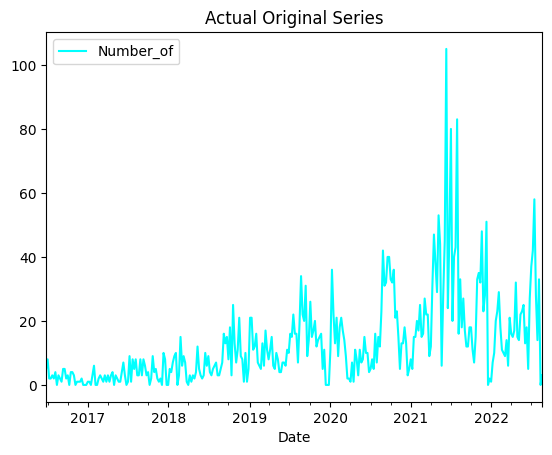

In [6]:
# Plotting Original sales data

first_week = pd.to_datetime('2016-07-04').date() # first week of stationary time series
test_end = pd.to_datetime('2022-08-22').date()
train_end = pd.to_datetime('2022-03-14').date()
train1,test1 = data[:train_end], data[train_end:]
data.plot(c='cyan', title=('Actual Original Series'))

In [7]:
# Looking at the plot It seems that our time series is not statioary.

In [8]:
# Using Dickey-Fuller test to determine if time series is stationary

def dickey_fuller_test(timeseries):    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag=7*8, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

dickey_fuller_test(data.Number_of)

Results of Dickey-Fuller Test:
Test Statistic                  -2.930123
p-value                          0.041956
#Lags Used                       6.000000
Number of Observations Used    315.000000
Critical Value (1%)             -3.451281
Critical Value (5%)             -2.870760
Critical Value (10%)            -2.571682
dtype: float64


<Axes: title={'center': 'Actual Stationary Series'}, xlabel='Date'>

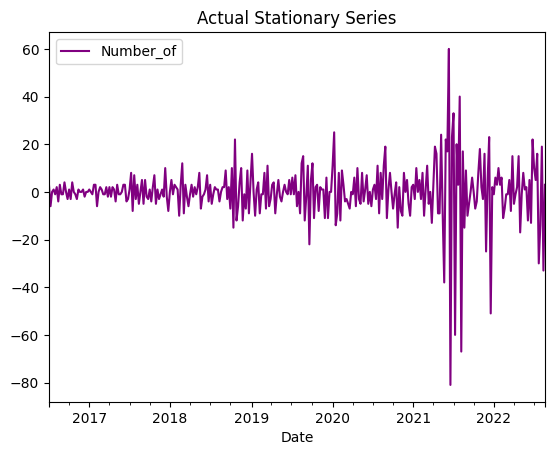

In [9]:
# Accourding to data plot and also test results, our data is not stationary, 
# so for more accurate prediction I try to make the time series stationary by differencing method.
# this way I get rid of the varying mean in time series.

data_delta = data.copy()
data_delta['delta_1'] = data['Number_of'].shift(1)
data_delta.replace([np.inf, -np.inf], np.nan, inplace=True)
data_delta.dropna(inplace=True)
data_delta['Number_of'] = data['Number_of'] - data_delta['delta_1']
data_delta.drop('delta_1', axis=1, inplace=True)
data_delta.plot(c='purple', title='Actual Stationary Series')

In [10]:
dickey_fuller_test(data_delta.Number_of)

Results of Dickey-Fuller Test:
Test Statistic                -1.117893e+01
p-value                        2.529412e-20
#Lags Used                     5.000000e+00
Number of Observations Used    3.150000e+02
Critical Value (1%)           -3.451281e+00
Critical Value (5%)           -2.870760e+00
Critical Value (10%)          -2.571682e+00
dtype: float64


In [11]:
# As test results show Test Statistic is more than Critical Value 
# and also the latter plot shows the resulting time series is stationary.

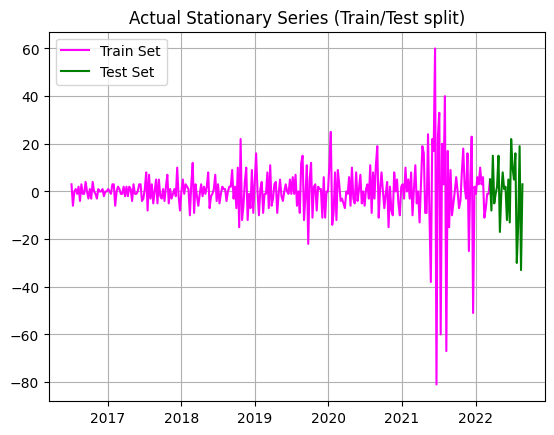

In [12]:
# Spliting data to train/test set

train, test = data_delta[:train_end], data_delta[train_end:]

fig, ax = plt.subplots()
ax.plot(train['Number_of'], c='magenta')
ax.plot(test['Number_of'], c='g')
ax.set_title('Actual Stationary Series (Train/Test split)')
ax.legend(['Train Set', 'Test Set'])
ax.grid(True)

In [13]:
# Trying simple grid search to find optimum parameters for SARIMA

def sarimax(data1, exo, all_param):
    results = []

    for param in all_param:
        try:
            mod = SARIMAX(data1,
                          exog = exo,
                          order=param[0],
                          seasonal_order=param[1])
            res = mod.fit()
            results.append((res,res.aic,param))
            print('Tried out SARIMAX{}x{} - AIC:{}'.format(param[0], param[1], res.aic))
            
        except Exception as e:
            print(e)
            continue
            
    return results

In [14]:
# Trying grid search to get optimum parameter set
# p,d,q = [1,2,3], [1], [1]
# P,D,Q,s = [1,2,3], [1], [1], [12,24,52]
p,d,q = [3], [1], [1]
P,D,Q,s = [1], [1], [1], [52]

# list of all parameter results
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq, seasonal_pdq))

all_res = sarimax(train, None, all_param)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.35755D+00    |proj g|=  1.21913D-01


 This problem is unconstrained.



At iterate    5    f=  3.25959D+00    |proj g|=  4.82508D-02

At iterate   10    f=  3.21459D+00    |proj g|=  2.06486D-02

At iterate   15    f=  3.20192D+00    |proj g|=  7.38755D-04

At iterate   20    f=  3.19986D+00    |proj g|=  2.69272D-02

At iterate   25    f=  3.19778D+00    |proj g|=  1.35211D-03

At iterate   30    f=  3.19740D+00    |proj g|=  5.85844D-03

At iterate   35    f=  3.19719D+00    |proj g|=  1.14644D-03

At iterate   40    f=  3.19716D+00    |proj g|=  3.73389D-04

At iterate   45    f=  3.19715D+00    |proj g|=  1.28767D-04

At iterate   50    f=  3.19715D+00    |proj g|=  6.49321D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [15]:
# Grid search results sorted by AIC
# 1919.5034484954276, ((3, 1, 1), (1, 1, 1, 52))),
# 1921.307782669695, ((3, 1, 1), (2, 1, 1, 52))), 
# 1923.273927767887, ((3, 1, 1), (3, 1, 1, 52))), 
# 1923.3692287369831, ((2, 1, 1), (1, 1, 1, 52))),
# 1925.1150968447193, ((2, 1, 1), (2, 1, 1, 52))),
# 1927.06146947163, ((2, 1, 1), (3, 1, 1, 52))), 
# 1944.1839564803759, ((1, 1, 1), (1, 1, 1, 52))),
# 1945.7998357395927, ((1, 1, 1), (2, 1, 1, 52))),
# 1947.5614972898088, ((1, 1, 1), (3, 1, 1, 52))),
# 2115.399703826012, ((3, 1, 1), (1, 1, 1, 24))), 
# 2115.85299660123, ((3, 1, 1), (2, 1, 1, 24))), 
# 2117.8153867234664, ((3, 1, 1), (3, 1, 1, 24))),
# 2121.0366114974204, ((2, 1, 1), (1, 1, 1, 24))),
# 2122.9370907082684, ((2, 1, 1), (2, 1, 1, 24))),
# 2124.9363206560506, ((2, 1, 1), (3, 1, 1, 24))),
# 2149.1758032559896, ((1, 1, 1), (1, 1, 1, 24))),
# 2150.3853778931198, ((1, 1, 1), (2, 1, 1, 24))),
# 2152.893432381814, ((1, 1, 1), (3, 1, 1, 24))), 
# 2180.012795949851, ((3, 1, 1), (3, 1, 1, 12))), 
# 2182.563804104461, ((3, 1, 1), (2, 1, 1, 12))), 
# 2183.8915761982753, ((3, 1, 1), (1, 1, 1, 12))),
# 2188.2362106752053, ((2, 1, 1), (3, 1, 1, 12))),
# 2191.1753938794245, ((2, 1, 1), (2, 1, 1, 12))),
# 2192.227675180673, ((2, 1, 1), (1, 1, 1, 12))), 
# 2218.7408113959677, ((1, 1, 1), (3, 1, 1, 12))),
# 2220.574026009933, ((1, 1, 1), (1, 1, 1, 12))), 
# 2221.107752196242, ((1, 1, 1), (2, 1, 1, 12)))]

all_res.sort(key=lambda x: x[1])
print(all_res[:5])

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x7fdc56462440>, 1919.5034484954276, ((3, 1, 1), (1, 1, 1, 52)))]


In [16]:
best_sarima_result = all_res[0][0]
# best_sarima_result.plot_diagnostics(figsize=(15, 12))

In [17]:
print("Ljung-box p-values:\n" + str(best_sarima_result.test_serial_correlation(method='ljungbox')[0][1]))
best_sarima_result.summary()

Ljung-box p-values:
[0.94624096 0.99706957 0.98924531 0.96547657 0.85413403 0.52470498
 0.12192282 0.1768394  0.13793338 0.0176942  0.01993753 0.03103954
 0.04070962 0.04832813 0.06714152 0.06907914 0.09375204 0.08097031
 0.07539771 0.04266456 0.04424945 0.0058979  0.00843646 0.00634248
 0.00579924 0.00447732 0.00398055 0.00492414 0.00429506 0.00541833
 0.0075036  0.00701025 0.00710881 0.00367937 0.00507918 0.00436254
 0.00425367 0.00537955 0.00651386 0.00491817 0.00332338 0.00432242
 0.00572355 0.00684789 0.00630167 0.0082552  0.01050188 0.01347822
 0.01549362]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Number_of   No. Observations:                  298
Model:             SARIMAX(3, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -952.752
Date:                            Sat, 04 Mar 2023   AIC                           1919.503
Time:                                    16:37:53   BIC                           1944.012
Sample:                                07-04-2016   HQIC                          1929.373
                                     - 03-14-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6277      0.050    -12.676      0.000      -0.725      -0.531
ar.L2         -0.3903      0.049     -8.022      0.000      -0.486      -0.295
ar.L3         -0.1546      0.033     -4.719      0.000      -0.219      -0.090
ma.L1         -0.9999      3.205     -0.312      0.755      -7.282       5.282
ar.S.L52       0.0326      0.271      0.120      0.904      -0.498       0.563
ma.S.L52      -0.5868      0.308     -1.903      0.057      -1.191       0.018
sigma2       124.4604    396.276      0.314      0.753    -652.226     901.147
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               834.22
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              11.64   Skew:                             0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
# Get prediction for test set
pred_test = best_sarima_result.get_prediction(start=pd.to_datetime(train_end), 
                                              end=test_end,
                                              exog=None)
shifted_test_data = data[pd.to_datetime(train_end):pd.to_datetime(test_end)]['Number_of'].shift(1)
pred_test_reverse = pred_test.predicted_mean + shifted_test_data.values
pred_test_reverse.dropna(inplace=True)

print('#########################################################')
err = 'Root mean squared error for test set: %.2f'% sqrt(MSE(test[1:], pred_test_reverse))
print(err)
print('#########################################################')

pred_all = best_sarima_result.get_prediction(start=pd.to_datetime(first_week), 
                                             end=test_end, 
                                             exog=None)
shifted_all_data = data[pd.to_datetime(first_week):pd.to_datetime(test_end)]['Number_of'].shift(1)
pred_all_reverse = pred_all.predicted_mean + shifted_all_data.values
pred_all_reverse.dropna(inplace=True)

#########################################################
Root mean squared error for test set: 36.34
#########################################################


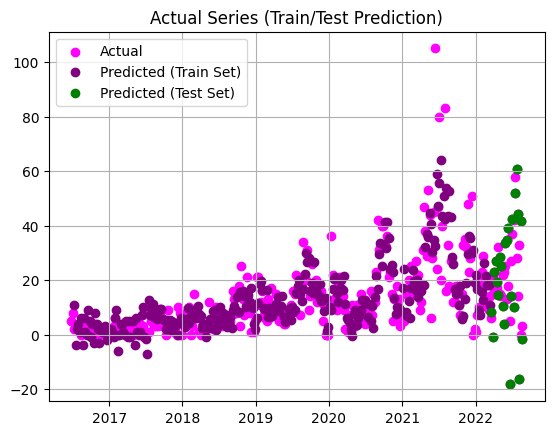

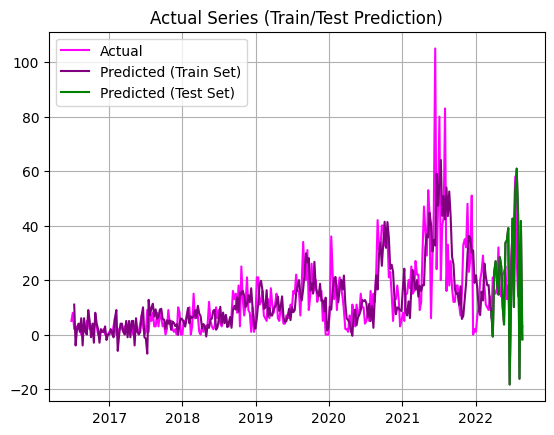

In [19]:
fig, ax = plt.subplots()

ax.scatter(
    x=data.index,
    y=data['Number_of'],
    c='magenta')

ax.scatter(
    x=data.loc[pd.to_datetime(first_week):pd.to_datetime(test_end)].index.values[1:],
    y=pred_all_reverse,
    c='purple')
    
ax.scatter(
    x=data[pd.to_datetime(train_end):pd.to_datetime(test_end)].index.values[1:],
    y=pred_test_reverse,
    c='g')
ax.set_title('Actual Series (Train/Test Prediction)')
ax.legend(['Actual', 'Predicted (Train Set)', 'Predicted (Test Set)'])
ax.grid(True)

fig, ax = plt.subplots()
ax.plot(data['Number_of'], c='magenta')
ax.plot(pred_all_reverse, c='purple')
ax.plot(pred_test_reverse, c='g')
ax.set_title('Actual Series (Train/Test Prediction)')
ax.legend(['Actual', 'Predicted (Train Set)', 'Predicted (Test Set)'])
ax.grid(True)

In [20]:
# Make multi step prediction set Date indeces
week_index = pd.to_datetime('2022-08-28').date().strftime(format='%Y-%m-%d')
week_list = [week_index]

month_count_to_multistep_prediction = 1

week_list = ['2022-08-29', '2022-09-05', '2022-09-12', '2022-09-19',
             '2022-09-26', '2022-10-03', '2022-10-10', '2022-10-17',
             '2022-10-24', '2022-10-31', '2022-11-07', '2022-11-14']
week_list = week_list[:1*4]

In [21]:
weekly_prediction = best_sarima_result.get_prediction(start=pd.to_datetime(week_list[0]), 
                                                      end=week_list[-1], 
                                                      exog=None)
weekly_prediction_shifted = weekly_prediction.predicted_mean.shift(1)
weekly_prediction_shifted.loc[pd.to_datetime(test_end) + timedelta(days=7)] = data.loc[pd.to_datetime(test_end)]['Number_of']

final_weekly_prediction = pd.DataFrame({'Date': week_list,
                                        'Number_of_3': weekly_prediction.predicted_mean.values + weekly_prediction_shifted.values})
final_weekly_prediction = final_weekly_prediction.set_index('Date')

train1.rename(columns={'Number_of': 'Number_of_1'}, inplace=True)
test1.rename(columns={'Number_of': 'Number_of_1'}, inplace=True)
pred_test_reverse = pd.DataFrame({'Date': test1.index.values[1:],
                                  'Number_of_2': pred_test_reverse}).set_index('Date')

test_actual_predicted = pd.merge(test1, pred_test_reverse, on='Date', how='left')
data_pred = pd.concat([train1, test_actual_predicted, final_weekly_prediction])
data_pred.reset_index(inplace=True)

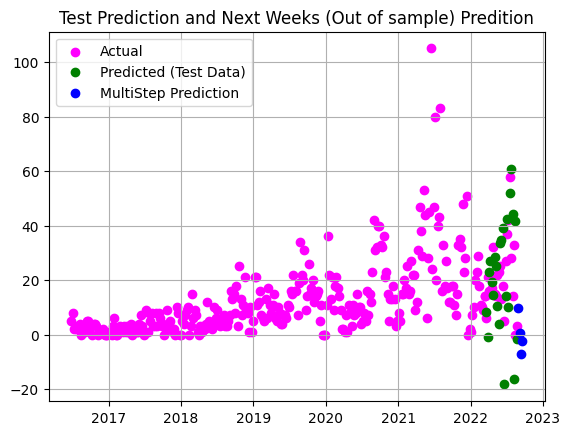

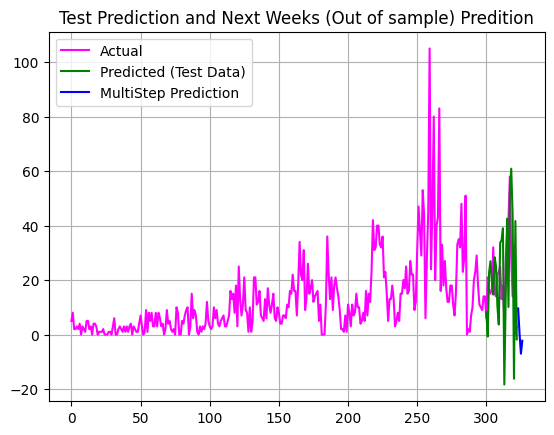

In [22]:
fig, ax = plt.subplots()
ax.scatter(
    x=data_pred['Date'],
    y=data_pred['Number_of_1'],
    c='magenta'
)
ax.scatter(
    x=data_pred['Date'],
    y=data_pred['Number_of_2'],
    c='g'
    )
ax.scatter(
    x=data_pred['Date'],
    y=data_pred['Number_of_3'],
    c='b'
    )
ax.set_title('Test Prediction and Next Weeks (Out of sample) Predition')    
ax.legend(['Actual', 'Predicted (Test Data)', 'MultiStep Prediction'])
ax.grid(True)

fig, ax = plt.subplots()
ax.plot(data_pred['Number_of_1'], c='magenta')
ax.plot(data_pred['Number_of_2'], c='g')
ax.plot(data_pred['Number_of_3'], c='b')
ax.set_title('Test Prediction and Next Weeks (Out of sample) Predition')
ax.legend(['Actual', 'Predicted (Test Data)', 'MultiStep Prediction'])
ax.grid(True)


In [23]:
print('Multi step sales prediction results:')
results = data_pred.copy()
results = results.tail(month_count_to_multistep_prediction * 4)
results['Number_of_3'] = results['Number_of_3'].astype(int)
results[['Date', 'Number_of_3']]

Multi step sales prediction results:


,Date,Number_of_3
323,2022-08-29,9
324,2022-09-05,0
325,2022-09-12,-7
326,2022-09-19,-2
